# SVI with Mixture of Gaussian posterior

In this notebook, stochastic VI is implemented in pytorch. <br/>
The prior is assumed to be `Gaussian` with fixed parameter values, <br/>
while the likelihood and approximate posterior are assumed as a `GMM`s.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
softplus = torch.nn.Softplus()
softmax = torch.nn.Softmax(dim=0)
num_samples = [100, 100]  # Number of samples
num_components = 2
num_steps = 3000


## Sampling
`gaussian_sample` function samples from a gaussian with reparameterization.<br />


In [4]:
def gaussian_sample(mean, std, num_samples, D=1):
    eps = torch.randn(size=(num_samples, D))
    z = eps * std + mean
    return z

`log_gmm` and `log_gaussian` compute log pdf of gmm and gaussian ditributions respectively. 

In [5]:
def log_gaussian(x, mean, std):
    return -0.5 * torch.log(2 * np.pi * std ** 2) - (0.5 * (1 / (std ** 2)) * (x - mean) ** 2)

def log_gmm(x, means, stds, log_pais):
    comp_log_dens = torch.stack([log_gaussian(x, mu, std) for (mu, std) in zip(means, stds)]).T
    log_weights = log_normalize(log_pais)
    return torch.logsumexp(comp_log_dens + log_weights, axis=-1, keepdims=False)

def log_normalize(x):
    return x - torch.logsumexp(x, 0)


Lets assume our approximate posterior, `q`,  is a mixture of Gaussians with two components,
our prior is a Gaussian and likelihood is also a mixture of Gaussians.


In [6]:
q_means = torch.nn.Parameter(torch.tensor([-4., 4.]), requires_grad=True)
q_stds = torch.nn.Parameter(torch.tensor([.8, .8]), requires_grad=True)
q_log_pais = torch.nn.Parameter(torch.log(torch.tensor([.3, .7])), requires_grad=True)
q_fn = lambda t: log_gmm(t, q_means, softplus(q_stds), q_log_pais)

In [7]:
p_means = torch.tensor([0.])
p_stds = torch.tensor([10.])
p_log_pais = torch.log(torch.tensor([1.]))
p_fn = lambda t: log_gmm(t, p_means, softplus(p_stds), p_log_pais)

In [8]:
likelihood_means = torch.tensor([-2., 2.])
likelihood_stds = torch.tensor([.8, 1.])
likelihood_log_pais = torch.log(torch.tensor([.4, .6]))
likelihood_fn = lambda t: log_gmm(t, likelihood_means, likelihood_stds, likelihood_log_pais)

We can plot the true posterior.

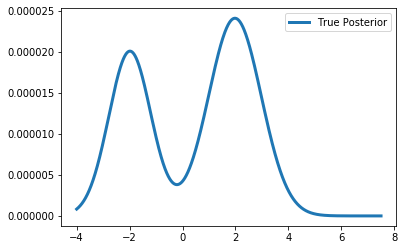

In [9]:
wn = torch.arange(-4., 7.5, 0.0001)
log_likelihood = likelihood_fn(wn)
log_prior = p_fn(wn)

log_true_posterior = log_likelihood + log_prior
log_true_posterior = log_true_posterior - torch.max(log_true_posterior)
true_posterior = torch.exp(log_true_posterior) / torch.sum(torch.exp(log_true_posterior))

posterior = torch.exp(q_fn(wn))

plt.plot(wn, true_posterior, linewidth=3, label="True Posterior")

plt.legend()
plt.show()

In [10]:
def compute_elbo():
    elbo = 0
    for c in range(num_components):
        # c = torch.randint(0, 2, [1]) ## we can replace the loop over comps with this line to sample the component
        z = gaussian_sample(q_means[c], softplus(q_stds[c]), num_samples[c])
        
        q_likelihood = torch.mean(q_fn(z))
        prior = torch.mean(p_fn(z))
        likelihood = torch.mean(likelihood_fn(z))
        elbo_c = q_likelihood - prior - likelihood
        elbo += elbo_c * softmax(q_log_pais)[c]
    return elbo

# Optimizer
We define an optimizer, and pass the variables that we intend to optimize. 

In [11]:
optimizer = torch.optim.Adam([
    {'params': [q_log_pais, q_means, q_stds], 'lr': 0.002}])

## Training

In [12]:
for step in range(num_steps):
    loss = compute_elbo()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if step % 250 == 0:
        print('Step:{} Loss: {:.6f}, '
              'means:{}, '
              'stds:{}, '
              'pais:{}'
              .format(step, loss.item(), q_means.data.numpy(), 
                      q_stds.data.numpy(),
                      softmax(q_log_pais).data.numpy())
             )

Step:0 Loss: 5.584110, means:[-3.998  3.998], stds:[0.79800004 0.79800004], pais:[0.2991607  0.70083934]
Step:250 Loss: 4.433443, means:[-3.559534   3.5152857], stds:[0.4437172 0.5713652], pais:[0.22220981 0.7777902 ]
Step:500 Loss: 4.032066, means:[-3.1507018  3.1105158], stds:[0.27322048 0.5459892 ], pais:[0.2715825  0.72841746]
Step:750 Loss: 3.582065, means:[-2.7402885  2.7979398], stds:[0.20705758 0.5322716 ], pais:[0.3546418 0.6453582]
Step:1000 Loss: 3.422817, means:[-2.403433  2.560725], stds:[0.20267664 0.53005224], pais:[0.40431005 0.59568995]
Step:1250 Loss: 3.288441, means:[-2.1839316  2.374353 ], stds:[0.21107657 0.5168753 ], pais:[0.41465437 0.5853456 ]
Step:1500 Loss: 3.256250, means:[-2.0669842  2.2360609], stds:[0.24958238 0.5033897 ], pais:[0.41274977 0.58725023]
Step:1750 Loss: 3.255167, means:[-2.0054834  2.1403167], stds:[0.21641731 0.50720656], pais:[0.40713173 0.5928683 ]
Step:2000 Loss: 3.252437, means:[-1.9846393  2.069825 ], stds:[0.22951575 0.5154245 ], pais:

## Plotting

No handles with labels found to put in legend.
/Users/farzaneh/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


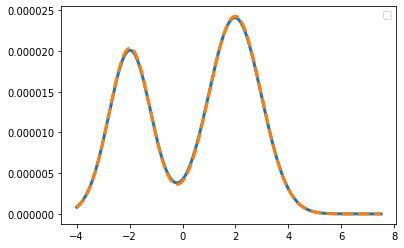

In [15]:
wn = torch.arange(-4., 7.5, 0.0001)
log_likelihood = likelihood_fn(wn)
log_prior = p_fn(wn)

log_true_posterior = log_likelihood + log_prior
log_true_posterior = log_true_posterior - torch.max(log_true_posterior)
true_posterior = torch.exp(log_true_posterior) / torch.sum(torch.exp(log_true_posterior))


posterior = torch.exp(q_fn(wn))

plt.plot(wn, true_posterior, linewidth=3, label="True Posterior")

plt.plot(wn, posterior.detach() / torch.sum(posterior.detach()), '--', linewidth=3, label="GMM")

plt.legend()
plt.show()